In [49]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [50]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

x = balanced_dataset.loc[:, 'Age':'Stress_Level']
y = balanced_dataset['Depression']

/\ Allgemeiner Code

\\/ Spezieller Code für das Hyperparameter Tuning

In [51]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

# Spaltennamen nach Typ trennen
categorical_cols = x.select_dtypes(include=['category']).columns.tolist()
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", RobustScaler(), numeric_cols), # StandardScaler() um Data Leakage zu vermeiden?
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])

x_processed = preprocessor.fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_processed, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train.values)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val.values)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test.values)), batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 755
Validation batches: 252
Test batches: 252


In [52]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [53]:
import optuna

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss, val_acc = evaluate(model, val_loader, criterion)  # Validate
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_acc, best_epoch

In [54]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns the best validation accuracy for this hyperparameter configuration.
    """
    # Define the search space
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Training the model with the sampled hyperparameters
    model = FlexibleClassifier(input_dim=19,hidden_dims=hidden_dims,output_dim=2,dropout_rate=dropout_rate)        
    best_val_acc, best_epoch = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial  # For Optuna pruning
    )
    
    return best_val_acc

In [59]:
study = optuna.create_study(
    direction='maximize',
    study_name='depression_classification',
    storage='sqlite:///optuna_depression.db',
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10
    )
)

n_trials = 50
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2026-02-26 19:56:11,808] Using an existing study with name 'depression_classification' instead of creating a new one.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-26 19:57:17,719] Trial 55 pruned. 
[I 2026-02-26 19:58:45,525] Trial 57 finished with value: 0.6787577639751553 and parameters: {'n_layers': 1, 'hidden_dim_layer_0': 128, 'weight_decay': 0.009411156050275177, 'learning_rate': 0.0005914773517519599, 'dropout_rate': 0.18650679272632298}. Best is trial 36 with value: 0.6879503105590062.
[I 2026-02-26 19:59:43,050] Trial 56 finished with value: 0.6837267080745342 and parameters: {'n_layers': 1, 'hidden_dim_layer_0': 128, 'weight_decay': 0.006370529512065555, 'learning_rate': 0.0006365832255581467, 'dropout_rate': 0.4541028543438237}. Best is trial 36 with value: 0.6879503105590062.
[I 2026-02-26 19:59:55,950] Trial 54 finished with value: 0.6837267080745342 and parameters: {'n_layers': 1, 'hidden_dim_layer_0': 128, 'weight_decay': 0.00701576970044633, 'learning_rate': 0.0011964137230026095, 'dropout_rate': 0.4833397187856053}. Best is trial 36 with value: 0.6879503105590062.
[I 2026-02-26 20:01:57,016] Trial 58 finished with val

In [60]:
best_params = study.best_trial.params

n_layers = best_params['n_layers']
hidden_dims = [best_params[f'hidden_dim_layer_{i}'] for i in range(n_layers)]

best_model = FlexibleClassifier(
    input_dim=19,
    hidden_dims=hidden_dims,
    output_dim=2,
    dropout_rate=best_params['dropout_rate']
)

best_val_acc, _ = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
)

print(f"  Best validation accuracy: {best_val_acc:.4f}")

  Best validation accuracy: 0.6870


In [61]:
from sklearn.metrics import classification_report

best_model.eval()
with torch.no_grad():
    test_outputs = best_model(torch.FloatTensor(x_test))
    _, y_pred = torch.max(test_outputs, 1)

target_names = ['Not Depressed', 'Depressed']
print(classification_report(y_test, y_pred.numpy(), target_names=target_names))

               precision    recall  f1-score   support

Not Depressed       0.67      0.73      0.70      2013
    Depressed       0.70      0.65      0.67      2012

     accuracy                           0.69      4025
    macro avg       0.69      0.69      0.69      4025
 weighted avg       0.69      0.69      0.69      4025



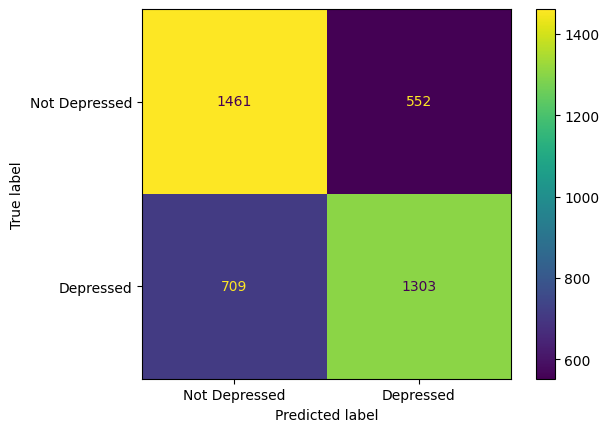

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.numpy(), display_labels=target_names)